# CMA/ES - Hierarchical - Bays09 - 5try: EM fits MSE scaled, more params

EM fits scaled, optimizing Threshold and Sparsity too

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [4]:
# both output layers
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-704374df-3b02-495e-aaa0-fa6002e70af4.npy').item()

# # 2nd layer output only.
# %cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_4try_emfitscaled_Mratiosigmaxsigmabaselinelapserate_repetitions3_100118/
# results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-745e3a89-520c-487a-8f78-cadd89492430.npy').item()


/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018


In [5]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [6]:
parameter_names_sorted

['M',
 'lapse_rate',
 'ratio_hierarchical',
 'sigma_baseline',
 'sigmax',
 'sparsity',
 'threshold']

In [7]:
metric = 'dist_emfit_scaled'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])
df_all_fits.loc[:, 'M'] = df_all_fits['M'].astype(int)

In [8]:
# Fix M and ratio_conj
ratio_hierarchical, M_lower, M_higher = utils.fix_ratiohierarchical(
    df_all_fits['M'], df_all_fits['ratio_hierarchical'])
df_all_fits.loc[:, 'ratio_hierarchical'] = ratio_hierarchical
df_all_fits.loc[:, 'M_lower'] = M_lower
df_all_fits.loc[:, 'M_higher'] = M_higher

In [9]:
df_all_fits.loc[:, metric + "_log"] = np.log(df_all_fits[metric])
df_all_fits.loc[:, metric + "_log10"] = np.log10(df_all_fits[metric])

In [10]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 200

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

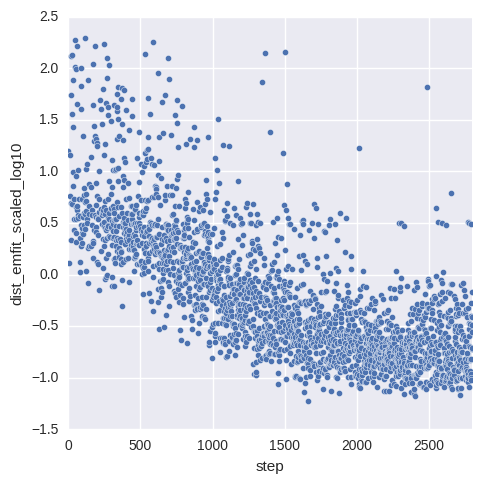

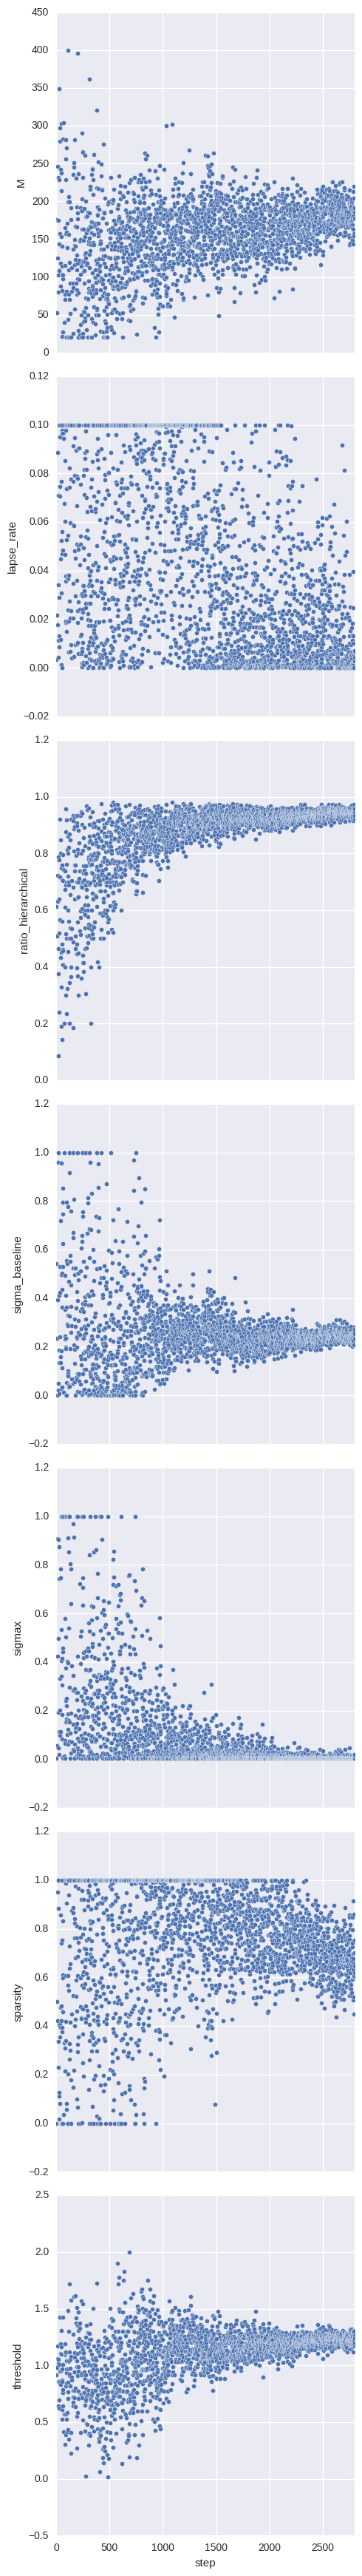

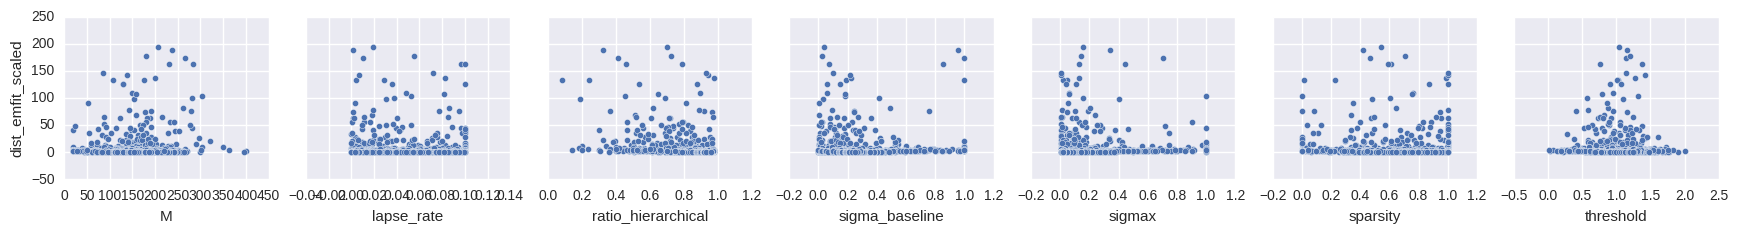

In [11]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric + "_log10"],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )
# g.set(yscale = 'log')


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [12]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] > 1000]
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
# result_to_color = np.log(result_to_color)

# parameters = ['M', 'ratio_hierarchical', 'sigma_baseline']
parameters = ['lapse_rate', 'M', 'sigma_baseline']

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj[parameters[0]],
        y = df_cmaes_traj[parameters[1]],
        z = df_cmaes_traj[parameters[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=parameters[0],
        ),
        yaxis=go.YAxis(
            title=parameters[1],
        ),
        zaxis=go.ZAxis(
            title=parameters[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [13]:
df_topparams = df_best_fits.sort_values(by='step', ascending=False).head(20)
df_topparams = df_best_fits.sort_values(by=metric, ascending=True).head(100)

# df_topparams_meld = pd.melt(df_topparams, id_vars=['step', 'dist_emfit_scaled'])
# df_topparams_meld.columns

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



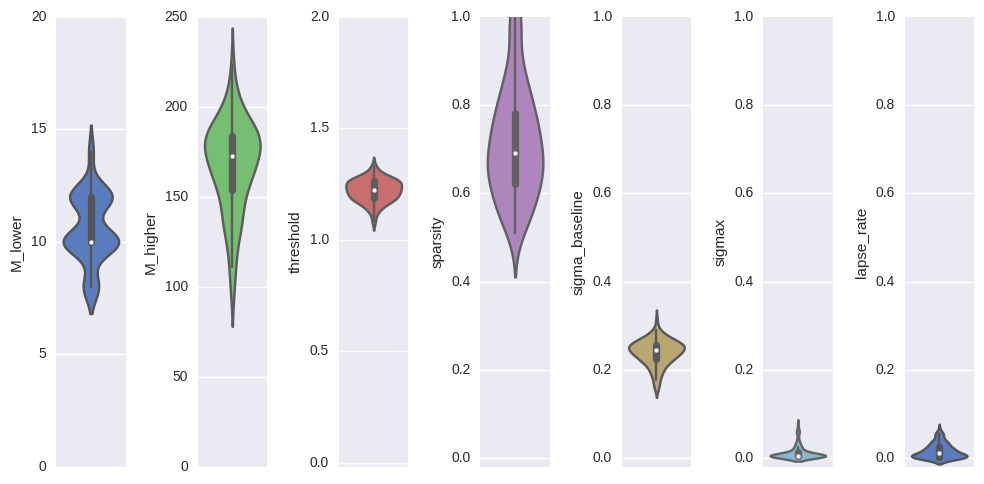

In [14]:
parameter_names_sorted = ['M_lower', 'M_higher', 'threshold', 'sparsity', 
                          'sigma_baseline', 'sigmax', 'lapse_rate']
colors = sns.color_palette('muted', n_colors=len(parameter_names_sorted))
fig_parameters, axes = plt.subplots(1, len(parameter_names_sorted), figsize=(10, 5))
axes = axes.flatten()
for i, param in enumerate(parameter_names_sorted):
#     sns.boxplot(df_topparams[param], orient='v', ax=axes[i], color=colors[i])
    sns.violinplot(df_topparams[param], orient='v', ax=axes[i], color=colors[i])
#     sns.barplot(df_topparams[param], orient='v', ax=axes[i], color=colors[i])
#     sns.swarmplot(df_topparams[param], orient='v', ax=axes[i], color='#000000', alpha=0.6, size=3, )

axes[0].set_ylim((-0.02, 20))
axes[1].set_ylim((-0.02, 250))
axes[2].set_ylim((-0.02, 2.))
for ax in axes[3:]:
    ax.set_ylim((-0.02, 1.0))
fig_parameters.set_tight_layout(True)

In [15]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(10).median().to_dict()
# df_bestparams = df_best_fits.sort_values(by=metric).iloc[:10]

df_bestparams

{'M': 186.0,
 'M_higher': 177.0,
 'M_lower': 10.0,
 'dist_emfit_scaled': 0.3010538706675169,
 'dist_emfit_scaled_log': -1.2034609440931077,
 'dist_emfit_scaled_log10': -0.5226564472057145,
 'lapse_rate': 0.00376118451782668,
 'ratio_hierarchical': 0.9477803228621291,
 'sigma_baseline': 0.2512783856615497,
 'sigmax': 0.006091673493637791,
 'sparsity': 0.6342094477960649,
 'step': 2794.5,
 'threshold': 1.235025784959792}

In [16]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             type_layer_one='feature',
                             output_both_layers=None,
                             normalise_weights=1,
                             ratio_hierarchical=0.5,
                             normalise_gain=None,
                             threshold=1.0,                  
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=10,
                             code_type='hierarchical',
                             slice_width=0.07,
                             burn_samples=10,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1500, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

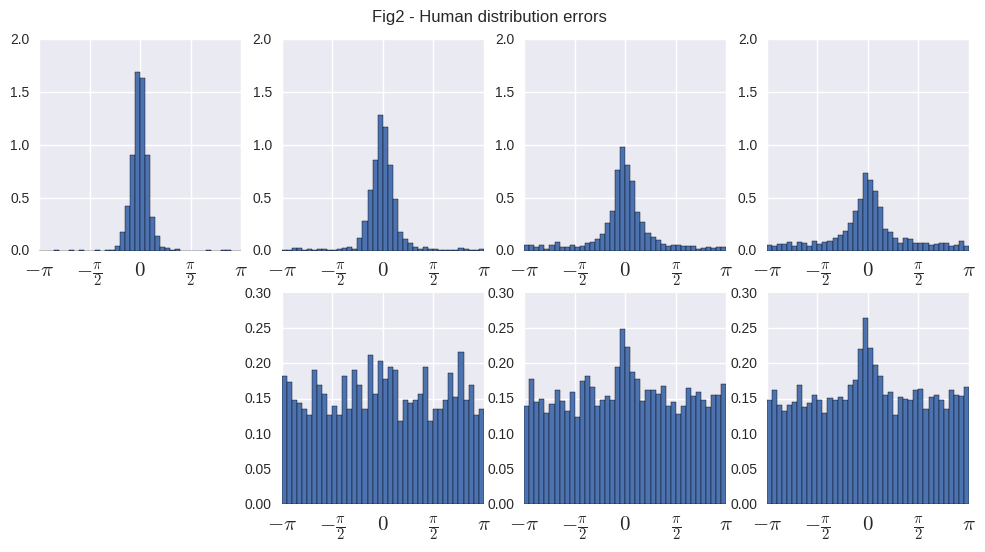

In [17]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

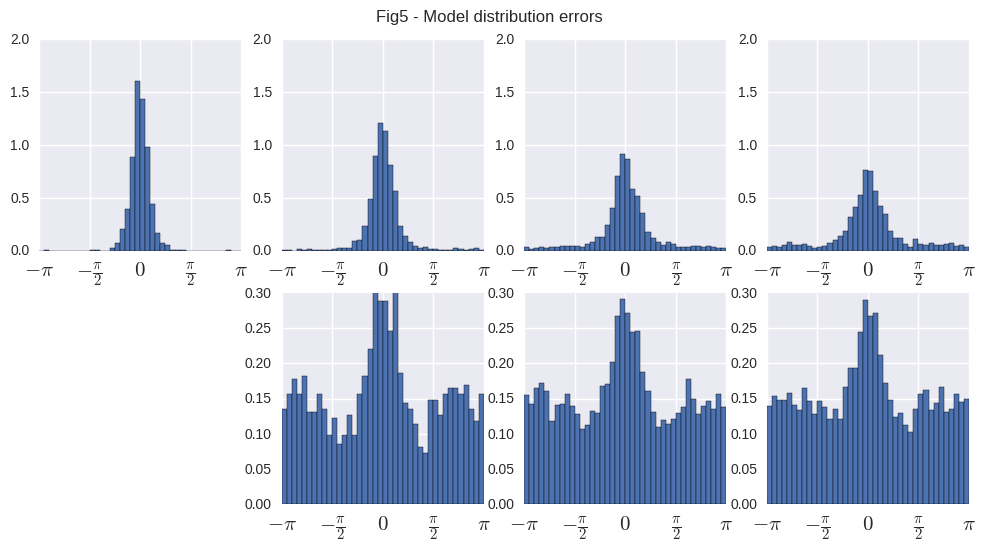

In [18]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

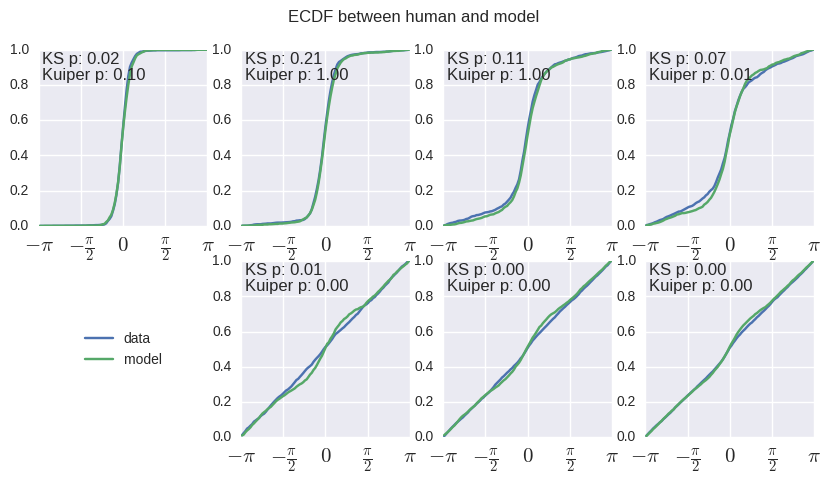

In [19]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

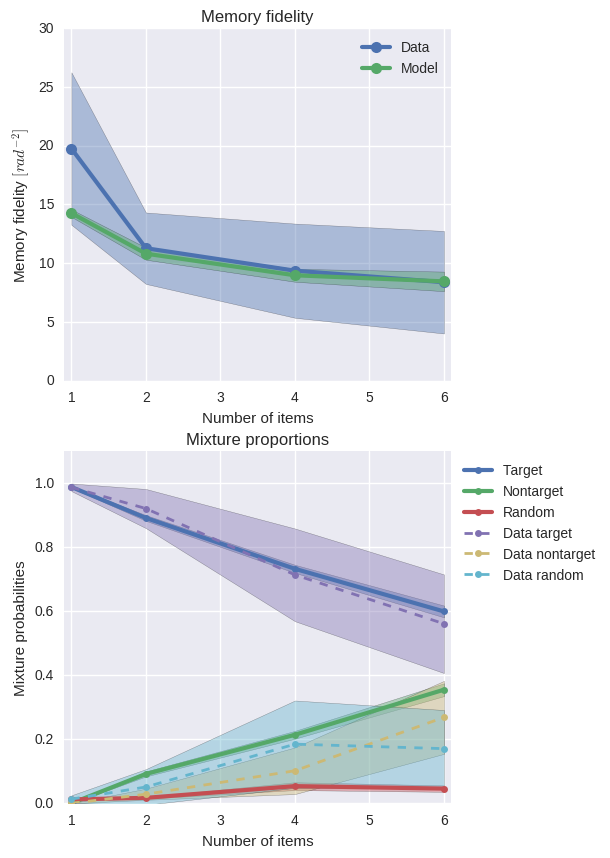

In [20]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Discussion: Better than before, adding two parameters helps

--> Used in thesis.

In [21]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_hier_bays09_emfitscaled_ptheta', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs/thesis_hier_bays09_emfitscaled_ptheta-f2f83531-39b4-47d5-b42d-9859ddef611a ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs /nfs/

In [22]:
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"), 
                              bbox_inches='tight')
axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"), 
                              bbox_inches='tight')
axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"),
                         bbox_inches='tight')
axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"), 
                               bbox_inches='tight')